In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
import statsmodels
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spike_statistics.core import permutation_resampling_test

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

In [3]:
#############################

zscore_str = "-no-zscore"
# zscore_str = ""

stim_loc = 'mec'
# stim_loc = 'ms'

#################################

In [4]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-lfp-response" + '-' + stim_loc + zscore_str)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [5]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [6]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [7]:
lfp_action = actions['stimulus-lfp-response' + zscore_str]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [8]:
lfp_results = pd.merge(sessions, lfp_results, how='left')

In [9]:
if stim_loc == 'ms':
    lfp_results = lfp_results.query('stim_location!="mecl" and stim_location!="mecr"')
elif stim_loc == 'mec':
    lfp_results = lfp_results.query('stim_location!="ms"')
else:
    raise AssertionError('')

In [10]:
def action_group(row):
    a = int(row.channel_group in [0,1,2,3])
    return f'{row.action}-{a}'
lfp_results['action_side_a'] = lfp_results.apply(action_group, axis=1)

In [11]:
lfp_results['stim_strength'] = lfp_results['stim_p_max'] / lfp_results['theta_bandpower']

In [12]:
# lfp_results_hemisphere = lfp_results.sort_values(
#     by=['action_side_a', 'stim_strength', 'signal_to_noise'], ascending=[True, False, False]
lfp_results_hemisphere = lfp_results.sort_values(
    by=['action_side_a', 'channel_group'], ascending=[True, False]
).drop_duplicates(subset='action_side_a', keep='first')
lfp_results_hemisphere.loc[:,['action_side_a','channel_group', 'signal_to_noise', 'stim_strength']].head()

,action_side_a,channel_group,signal_to_noise,stim_strength
71,1833-010719-1-0,7,0.001902,NaN
67,1833-010719-1-1,3,0.003522,NaN
583,1833-020719-1-0,7,-0.002942,NaN
579,1833-020719-1-1,3,0.012323,NaN
375,1833-020719-3-0,7,-0.002042,NaN


In [13]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
# Hz11 means that the baseline session was indeed before an 11 Hz session
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [14]:
# prepare pairwise comparison: same animal same side same date different sessions

In [15]:
def make_entity_date_side(row):
    s = row.action_side_a.split('-')
    del s[2]
    return '-'.join(s)

In [16]:
lfp_results_hemisphere['entity_date_side'] = lfp_results_hemisphere.apply(make_entity_date_side, axis=1)

In [17]:
from functools import reduce

In [18]:
keys = [
    'theta_bandpower',
    'theta_relpower',
    'theta_relpeak',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'stim_bandpower',
    'stim_relpower',
    'stim_relpeak',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
]

results = {}
for key in keys:
    results[key] = list()
    for query, label in zip(queries, labels):
        values = lfp_results_hemisphere.query(query).loc[:,['entity_date_side', key]]
        results[key].append(values.rename({key: label}, axis=1))
        
for key, val in results.items():
    df = reduce(lambda  left,right: pd.merge(left, right, on='entity_date_side', how='outer'), val)
    results[key] = df.drop('entity_date_side', axis=1)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future

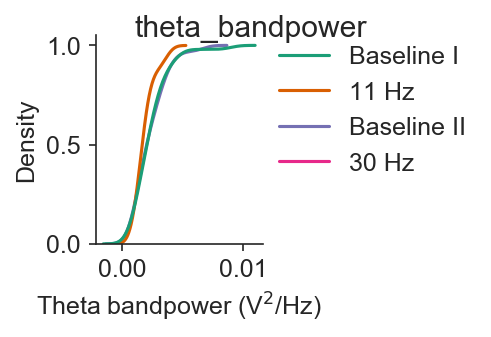

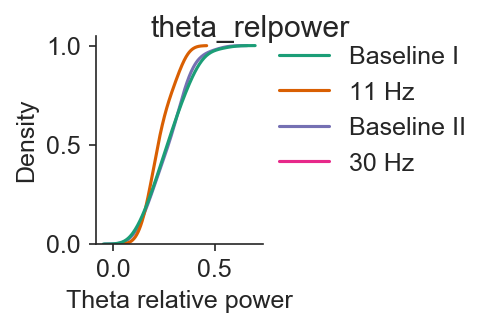

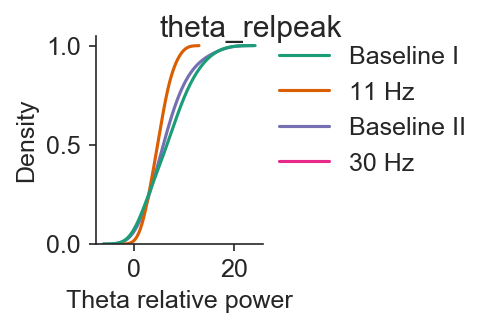

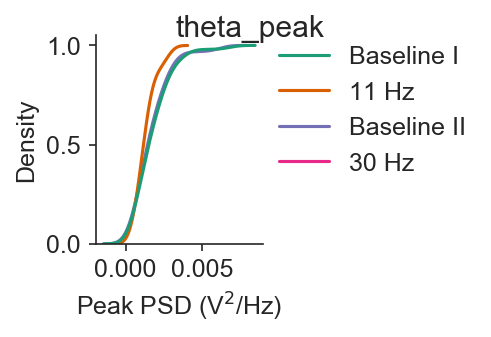

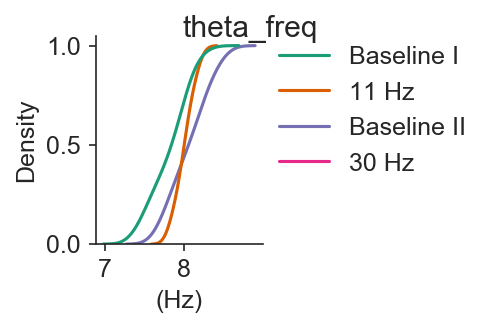

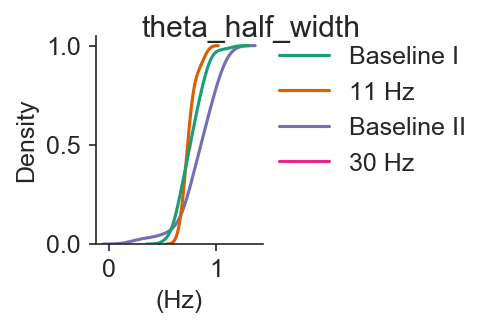

In [19]:
xlabel = {
    'theta_bandpower': 'Theta bandpower (V$^2$/Hz)',
    'theta_relpower': 'Theta relative power',
    'theta_relpeak': 'Theta relative power',
    'theta_peak': 'Peak PSD (V$^2$/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}

for key in xlabel:
    fig = plt.figure(figsize=(3.5,2))
    plt.suptitle(key)
    legend_lines = []
    for color, label in zip(colors, labels):
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
    sns.kdeplot(data=results[key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future

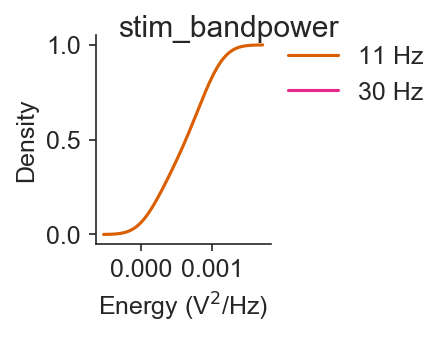

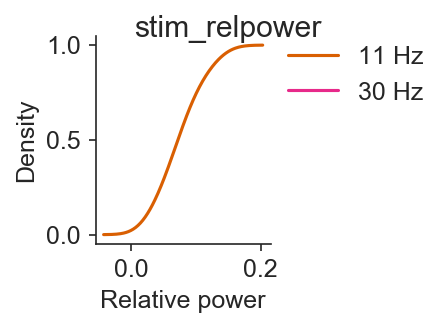

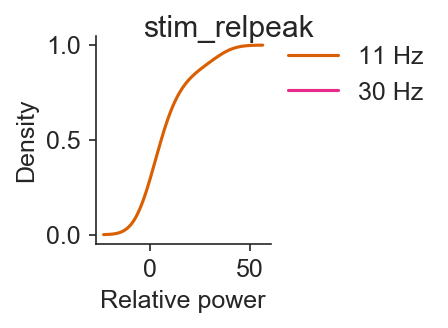

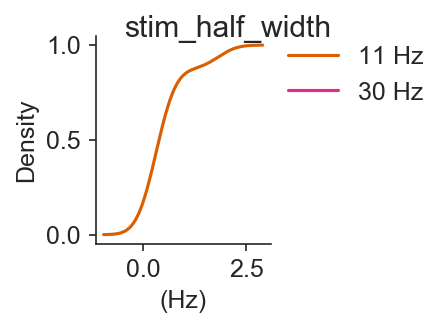

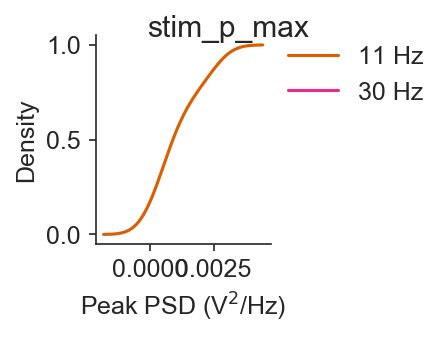

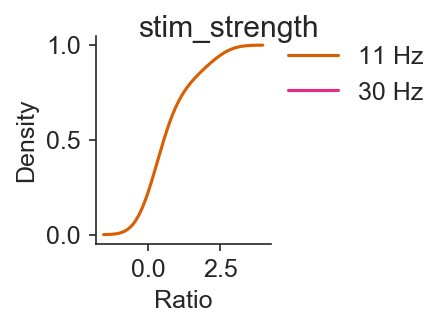

In [20]:
xlabel = {
    'stim_bandpower': 'Energy (V$^2$/Hz)',
    'stim_relpower': 'Relative power',
    'stim_relpeak': 'Relative power',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (V$^2$/Hz)',
    'stim_strength': 'Ratio',
}
for key in xlabel:
    fig = plt.figure(figsize=(3.2,2))
    plt.suptitle(key)
    legend_lines = []
    for color, label in zip(colors[1::2], labels[1::2]):
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
    sns.kdeplot(data=results[key].loc[:, labels[1::2]], cumulative=True, legend=False, palette=colors[1::2], common_norm=False)
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

In [21]:
def summarize(data):
    return "{:.1e} ± {:.1e} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(df, keys):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

    return "{:.1e}, {:.1e}, ({})".format(statistic, pvalue, len(dff))


def summarize_wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()


    return"{:.1e} ± {:.1e}, {:.1e} ± {:.1e} ({})".format(dff[keys[0]].mean(), dff[keys[0]].sem(), dff[keys[1]].mean(), dff[keys[1]].sem(), len(dff))


def paired_t(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.ttest_rel(
        dff[keys[0]], 
        dff[keys[1]])

    return "{:.2f}, {:.3f}".format(statistic, pvalue)

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.1e}, {:.1e}".format(statistic, pvalue)


def shapiro(df, key):
    statistic, pvalue = scipy.stats.shapiro(
        df[key].dropna())

    return "{:.2f}, {:.3f}".format(statistic, pvalue)

def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [22]:


stat = pd.DataFrame()

for key, df in results.items():
    Key = rename(key)
    stat[Key] = df.agg(summarize)
    stat[Key] = df.agg(summarize)

    for i, c1 in enumerate(df.columns):
        try:
            stat.loc[f'Normality {c1}', Key] = normality(df, c1)
        except:
            stat.loc[f'Normality {c1}', Key] = np.nan
#         stat.loc[f'Shapiro {c1}', Key] = shapiro(df, c1)
        for c2 in df.columns[i+1:]:
#             stat.loc[f'MWU {c1} {c2}', Key] = MWU(df, [c1, c2])
#             stat.loc[f'PRS {c1} {c2}', Key] = PRS(df, [c1, c2])
            try:
                stat.loc[f'Wilcoxon {c1} {c2}', Key] = wilcoxon(df, [c1, c2])
            except:
                stat.loc[f'Wilcoxon {c1} {c2}', Key] = np.nan
#             stat.loc[f'Paired T {c1} {c2}', Key] = paired_t(df, [c1, c2])
            stat.loc[f'Paired summary {c1} {c2}', Key] = summarize_wilcoxon(df, [c1, c2])

stat.sort_index()

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation do

,Theta bandpower,Theta relpower,Theta relpeak,Theta peak,Theta freq,Theta half width,Stim bandpower,Stim relpower,Stim relpeak,Stim half width,Stim p max,Stim strength
11 Hz,1.8e-03 ± 2.9e-04 (8),2.3e-01 ± 2.3e-02 (8),4.8e+00 ± 7.8e-01 (8),1.3e-03 ± 2.4e-04 (8),8.0e+00 ± 4.5e-02 (8),7.4e-01 ± 2.4e-02 (8),6.1e-04 ± 1.2e-04 (8),7.4e-02 ± 1.2e-02 (8),8.2e+00 ± 4.1e+00 (8),5.1e-01 ± 1.9e-01 (8),1.1e-03 ± 3.5e-04 (8),7.0e-01 ± 2.9e-01 (8)
30 Hz,nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0)
Baseline I,2.3e-03 ± 2.0e-04 (50),2.7e-01 ± 1.5e-02 (50),6.8e+00 ± 6.4e-01 (50),1.7e-03 ± 1.7e-04 (50),7.8e+00 ± 3.7e-02 (50),7.6e-01 ± 1.7e-02 (50),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0)
Baseline II,2.2e-03 ± 2.3e-04 (32),2.7e-01 ± 1.7e-02 (32),6.3e+00 ± 7.4e-01 (32),1.6e-03 ± 2.1e-04 (32),8.1e+00 ± 4.7e-02 (32),8.4e-01 ± 3.2e-02 (32),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0)
Normality 11 Hz,"9.8e+00, 7.4e-03","1.1e+00, 5.8e-01","3.0e-01, 8.6e-01","6.5e+00, 3.8e-02","1.2e+00, 5.6e-01","7.0e+00, 3.1e-02","1.4e+00, 5.0e-01","3.0e-01, 8.6e-01","8.3e+00, 1.6e-02","2.0e+01, 5.0e-05","1.5e+00, 4.6e-01","5.5e+00, 6.5e-02"
Normality 30 Hz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Normality Baseline I,"4.3e+01, 5.2e-10","1.2e+00, 5.5e-01","2.4e+00, 3.0e-01","3.0e+01, 3.2e-07","4.6e+00, 9.8e-02","2.5e+00, 2.8e-01",NaN,NaN,NaN,NaN,NaN,NaN
Normality Baseline II,"1.4e+01, 1.1e-03","3.6e-01, 8.3e-01","4.9e+00, 8.8e-02","2.5e+01, 3.4e-06","4.7e+00, 9.7e-02","1.6e+01, 2.8e-04",NaN,NaN,NaN,NaN,NaN,NaN
Paired summary 11 Hz 30 Hz,"nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)"
Paired summary 11 Hz Baseline II,"nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)","nan ± nan, nan ± nan (0)"


In [23]:
stat.to_latex(output_path / "statistics" / f"statistics.tex")
stat.to_csv(output_path / "statistics" / f"statistics.csv")

In [24]:
for key, result in results.items():
    result.to_latex(output_path / "statistics" / f"values_{key}.tex")
    result.to_csv(output_path / "statistics" / f"values_{key}.csv")

# Plot PSD

In [25]:
psd = pd.read_feather(pathlib.Path("output") / ("stimulus-lfp-response" + zscore_str) / 'data' / 'psd.feather')
freqs = pd.read_feather(pathlib.Path("output") / ("stimulus-lfp-response" + zscore_str) / 'data' / 'freqs.feather')

In [26]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [27]:
freq = freqs.T.iloc[0].values

mask = (freq < 49)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


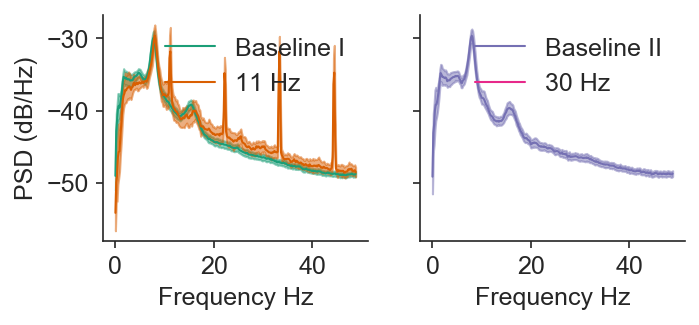

In [28]:

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
axs = axs.repeat(2)
for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
    selection = [
        f'{r.action}_{r.channel_group}' 
        for i, r in lfp_results_hemisphere.query(query).iterrows()]
    values = psd.loc[mask, selection].to_numpy()
    values = 10 * np.log10(values)
    plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
#     ax.set_title(titles[i])
    ax.set_xlabel('Frequency Hz')
    ax.legend(frameon=False)
axs[0].set_ylabel('PSD (dB/Hz)')
# axs[0].set_ylim(-31, 1)
despine()

figname = 'lfp-psd'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [29]:
action = project.require_action("stimulus-lfp-response" + '-' + stim_loc + zscore_str)

In [30]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_stim_bandpower.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_stim_relpeak.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_theta_half_width.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_theta_bandpower.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_stim_relpower.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_stim_half_width.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_theta_energy.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/values_theta_freq.csv',
 '/media/storage/expi

In [31]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-lfp-response.ipynb")